# 2. Features Hypothesis Test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, sem, t

In [2]:
df = pd.read_csv('../database/companies/original/2016-2023.csv')
# Exclude the data in 2023
df = df[df['year']!=2023]

/var/folders/kw/6hnl881s2p9701b42gpjt_pr0000gn/T/ipykernel_20420/633881125.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../database/companies/original/2016-2023.csv')


In [3]:
governance = ["ceo_is_female","unequal_voting","ceo_tenure","board_size","classified_board_system","poison_pill","buyback_yield",
              "dividend_payout_ratio","cf_to_total_compensation_to_executives","cf_to_total_compensation_to_board_members"]

operation = ["cf_to_capex_industry_peers_percentile","net_debt_to_ebitda_industry_peers_percentile",
             "current_ratio_industry_peers_percentile","ebitda_margin_industry_peers_percentile",
             "sales_to_total_assets_industry_peers_percentile","employee_growth_rate_industry_peers_percentile",
             "fcf_yield_industry_peers_percentile","sales_growth_rate_industry_peers_percentile",
             "cash_conversion_cycle_industry_peers_percentile","interest_coverage_ratio_industry_peers_percentile"]

ownership = ["free_float_percentage","institution_ownership_percentage","insider_shares_percentage"]

technical = ['rsi_14d','rsi_30d','volatility_30d','volatility_90d','volatility_180d',"volume_30d_average_to_outstanding"]

returns = ['total_return_5y', 'total_return_4y', 'total_return_3y','total_return_2y', 'total_return_1y', 'total_return_6m','total_return_3m']


valuation = ["roe_industry_peers_percentile","operating_roic_industry_peers_percentile","pe_ratio_industry_peers_percentile",
             "eps_industry_peers_percentile","ev_to_sales_industry_peers_percentile","tobin_q_ratio_industry_peers_percentile",
             "pb_ratio_industry_peers_percentile","asset_to_equity_industry_peers_percentile","ev_ebitda_industry_peers_percentile", "ev_to_asset_industry_peers_percentile"]

binary = ["unequal_voting", "classified_board_system","poison_pill"]

features = governance + operation + ownership + technical + returns + valuation

## 1. Conduct the t-test

In [4]:
def get_significance(p):
    if p > 0.05:
        return 'ns'
    elif p <= 0.0001:
        return '****'
    elif p <= 0.001:
        return '***'
    elif p <= 0.01:
        return '**'
    else:  # p <= 0.05
        return '*'

In [5]:
results = []

df_targeted = df[df['targeted'] == 1]
df_not_targeted = df[df['targeted'] == 0]
total_rows = len(df)  # Total number of rows for calculating missing percentage

for feature in features:
    # Combine targeted and not-targeted for missing value calculation
    combined = df[feature]
    
    missing_count = combined.isna().sum()  # Count missing values for the feature
    missing_percentage = (missing_count / total_rows) * 100  # Calculate percentage of missing values
    
    targeted = df_targeted[feature].dropna()
    not_targeted = df_not_targeted[feature].dropna()
    
    mean_targeted = targeted.mean()
    mean_not_targeted = not_targeted.mean()
    
    # Standard errors
    se_targeted = sem(targeted)
    se_not_targeted = sem(not_targeted)
    
    # Degrees of freedom
    n_targeted = len(targeted) - 1
    n_not_targeted = len(not_targeted) - 1
    
    # T-scores for 95% CI
    t_score_targeted = t.ppf(0.975, n_targeted)
    t_score_not_targeted = t.ppf(0.975, n_not_targeted)
    
    # Confidence intervals
    ci_targeted = (mean_targeted - t_score_targeted * se_targeted, mean_targeted + t_score_targeted * se_targeted)
    ci_not_targeted = (mean_not_targeted - t_score_not_targeted * se_not_targeted, mean_not_targeted + t_score_not_targeted * se_not_targeted)
    
    # T-test
    t_stat, p_value = ttest_ind(targeted, not_targeted, alternative='two-sided')
    
    # Append results including missing value data
    results.append({
        'Feature': feature,
        'mean_targeted': mean_targeted,
        'mean_not_targeted': mean_not_targeted,
        'targeted_95CI_left': ci_targeted[0],
        'targeted_95CI_right': ci_targeted[1],
        'not_targeted_95CI_left': ci_not_targeted[0],
        'not_targeted_95CI_right': ci_not_targeted[1],
        't value': t_stat,
        'p value': p_value,
        'missing_count': missing_count,
        'missing_percentage': missing_percentage
    })

# Create DataFrame
df_results = pd.DataFrame(results)

# Apply the significance function to the 'p value' column to categorize significance levels
df_results['significance'] = df_results['p value'].apply(get_significance)


In [6]:
df_results

,Feature,mean_targeted,mean_not_targeted,targeted_95CI_left,targeted_95CI_right,not_targeted_95CI_left,not_targeted_95CI_right,t value,p value,missing_count,missing_percentage,significance
0,ceo_is_female,0.050776,0.052640,0.034577,0.066975,0.049353,0.055928,-0.218155,8.273108e-01,981,5.053054,ns
1,unequal_voting,0.073759,0.085995,0.054418,0.093100,0.081889,0.090102,-1.139466,2.545235e-01,801,4.125889,ns
2,ceo_tenure,7.053785,7.768888,6.528612,7.578959,7.663207,7.874568,-2.589143,9.628866e-03,449,2.312764,**
3,board_size,8.972299,9.171505,8.818770,9.125828,9.136079,9.206931,-2.162455,3.059556e-02,471,2.426084,*
4,classified_board_system,0.365297,0.397629,0.328381,0.402212,0.390225,0.405033,-1.662068,9.651703e-02,1970,10.147316,ns
5,poison_pill,0.043348,0.027828,0.027878,0.058819,0.025368,0.030288,2.370759,1.776219e-02,1568,8.076646,*
6,buyback_yield,0.124227,0.040331,-0.068774,0.317228,0.021914,0.058749,1.684205,9.216719e-02,7041,36.267642,ns
7,dividend_payout_ratio,27.733682,34.463211,20.940082,34.527281,33.074353,35.852069,-1.875327,6.076319e-02,538,2.771196,ns
8,cf_to_total_compensation_to_executives,53.985829,98.907454,2.355306,105.616351,62.806195,135.008714,-0.502280,6.154777e-01,3176,16.359328,ns
9,cf_to_total_compensation_to_board_members,615.886090,998.766073,-375.862184,1607.634364,680.262566,1317.269581,-0.481990,6.298195e-01,3277,16.879571,ns


## 2. Plot the graph with CIs

In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

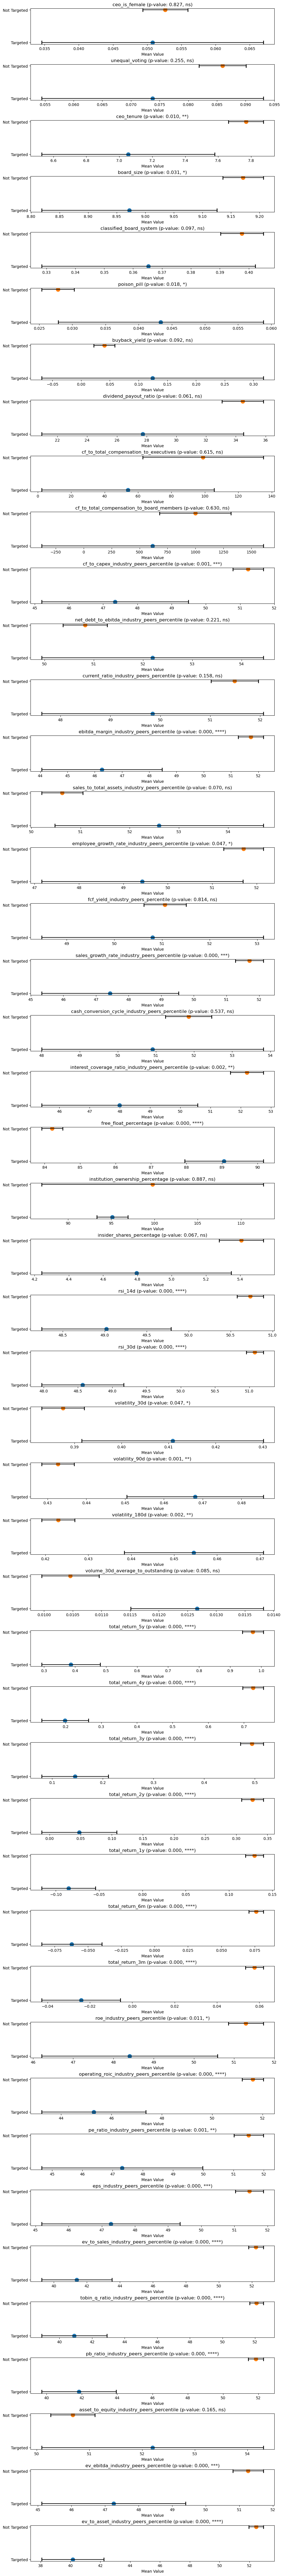

In [8]:
num_features = len(features)
fig_width = 10
fig_height = max(2 * num_features, 10)  # Adjust figure height based on the number of features
fig, axes = plt.subplots(num_features, 1, figsize=(fig_width, fig_height), constrained_layout=True)

# Ensure 'axes' is iterable when there's only one feature
if num_features == 1:
    axes = [axes]

for i, feature in enumerate(features):
    ax = axes[i] if num_features > 1 else axes
    
    # Adjusting the positions slightly towards the center
    positions = [0, 1]  # Adjusted Y positions
    
    # Extracting data for the current feature and other steps remain the same
    row = df_results[df_results['Feature'] == feature].iloc[0]
    means = [row['mean_targeted'], row['mean_not_targeted']]
    ci_targeted = [row['targeted_95CI_left'], row['targeted_95CI_right']]
    ci_not_targeted = [row['not_targeted_95CI_left'], row['not_targeted_95CI_right']]
    
    xerr_targeted = [[means[0] - ci_targeted[0]], [ci_targeted[1] - means[0]]]
    xerr_not_targeted = [[means[1] - ci_not_targeted[0]], [ci_not_targeted[1] - means[1]]]
    
    # Plot the point for the mean value
    ax.plot(means[0], positions[0], 'o', color='tab:blue', markersize=10)  # Targeted
    ax.plot(means[1], positions[1], 'o', color='tab:orange', markersize=10)  # Not Targeted
    
    # Adding error lines for 95% CIs
    ax.errorbar(means[0], positions[0], xerr=xerr_targeted, fmt='none', capsize=5, color='black', capthick=2)
    ax.errorbar(means[1], positions[1], xerr=xerr_not_targeted, fmt='none', capsize=5, color='black', capthick=2)
    
    # Customizing the plot
    ax.set_yticks(positions)
    ax.set_yticklabels(['Targeted', 'Not Targeted'])
    ax.set_xlabel('Mean Value')
    
    # Setting the title to include the feature name and p-value
    p_value = row['p value']
    significance = row['significance']
    ax.set_title(f'{feature} (p-value: {p_value:.3f}, {significance})')

plt.show()


## 3. Check the features with different signficance level

### 3.1. not significant (0.05 < p value)

In [9]:
df_results[df_results['significance']=='ns'][['Feature', 'p value', 'missing_percentage']]

,Feature,p value,missing_percentage
0,ceo_is_female,0.827311,5.053054
1,unequal_voting,0.254524,4.125889
4,classified_board_system,0.096517,10.147316
6,buyback_yield,0.092167,36.267642
7,dividend_payout_ratio,0.060763,2.771196
8,cf_to_total_compensation_to_executives,0.615478,16.359328
9,cf_to_total_compensation_to_board_members,0.629819,16.879571
11,net_debt_to_ebitda_industry_peers_percentile,0.220549,15.998764
12,current_ratio_industry_peers_percentile,0.158087,23.519110
14,sales_to_total_assets_industry_peers_percentile,0.070090,2.117029


### 3.2. \* (0.01 < p value <= 0.05)

In [10]:
df_results[df_results['significance']=='*'][['Feature', 'p value', 'missing_percentage']]

,Feature,p value,missing_percentage
3,board_size,0.030596,2.426084
5,poison_pill,0.017762,8.076646
15,employee_growth_rate_industry_peers_percentile,0.046691,14.407129
25,volatility_30d,0.047386,0.396621
36,roe_industry_peers_percentile,0.011187,9.683733


### 3.3. \** (0.001 < p value <= 0.01)

In [11]:
df_results[df_results['significance']=='**'][['Feature', 'p value', 'missing_percentage']]

,Feature,p value,missing_percentage
2,ceo_tenure,0.009629,2.312764
19,interest_coverage_ratio_industry_peers_percentile,0.001641,42.237561
26,volatility_90d,0.001065,0.396621
27,volatility_180d,0.001542,0.396621
38,pe_ratio_industry_peers_percentile,0.001442,27.959205


### 3.4. \*** (0.0001 < p value <= 0.001) 

In [12]:
df_results[df_results['significance']=='***'][['Feature', 'p value', 'missing_percentage']]

,Feature,p value,missing_percentage
10,cf_to_capex_industry_peers_percentile,0.000518,13.165757
17,sales_growth_rate_industry_peers_percentile,0.000101,5.892655
39,eps_industry_peers_percentile,0.000129,2.657876
44,ev_ebitda_industry_peers_percentile,0.000363,16.318121


### 3.5. \**** ( p value <= 0.0001) 

In [13]:
df_results[df_results['significance']=='****'][['Feature', 'p value', 'missing_percentage']]

,Feature,p value,missing_percentage
13,ebitda_margin_industry_peers_percentile,1.488310e-06,19.372618
20,free_float_percentage,2.364294e-10,0.056660
23,rsi_14d,2.403025e-05,0.453281
24,rsi_30d,9.400554e-15,0.520243
29,total_return_5y,5.699882e-12,21.639023
30,total_return_4y,4.793086e-13,16.596271
31,total_return_3y,1.216489e-09,10.858144
32,total_return_2y,6.292280e-10,4.975791
33,total_return_1y,4.037098e-16,2.652725
34,total_return_6m,1.773968e-22,1.411353
